## Paqueterías

In [1]:
# Pymoo Baselines
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.problems.many.wfg import WFG1
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions

# NSGA-3
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from scipy.linalg import LinAlgError
from scipy.spatial.distance import cdist

# Pareto Q-Learning
import mo_gymnasium as mo_gym
from collections import defaultdict


# Métodos de descenso
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torch.nn.functional as F
from torch.distributions import Categorical

## Pymoo Baseline

In [2]:
wfg = WFG1(n_var = 24, n_obj = 3)
ngsa2 = NSGA2(pop_size = 100)

ref_dirs = get_reference_directions('das-dennis', 3, n_partitions = 12)
ngsa3 = NSGA3(pop_size = 92, ref_dirs = ref_dirs)

print("Objetivos: {}. Variables: {}. Restricciones: {}.".format(wfg.n_obj, wfg.n_var, wfg.n_constr))
print("X Lower bounds: {}. X Upper bounds: {}. Optimize value type: {}.".format(wfg.xl, wfg.xu, wfg.vtype))

Objetivos: 3. Variables: 24. Restricciones: 0.
X Lower bounds: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]. X Upper bounds: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40. 42. 44. 46. 48.]. Optimize value type: <class 'float'>.


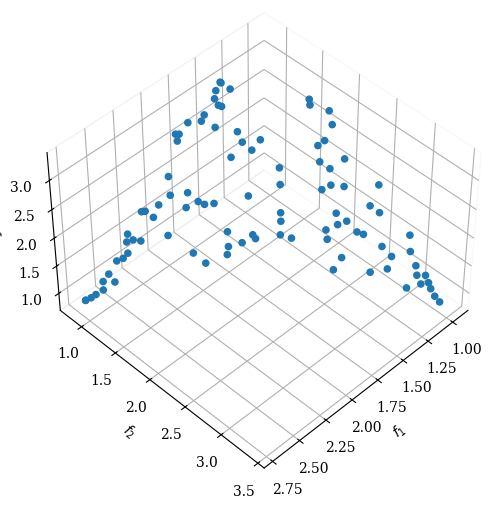

In [3]:
res_ngsa2 = minimize(
    wfg,
    ngsa2,
    ('n_gen', 300),
    seed = 42,
    verbose = False
)

Scatter().add(res_ngsa2.F).show()

C:\Users\Frank\anaconda3\envs\pcic\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


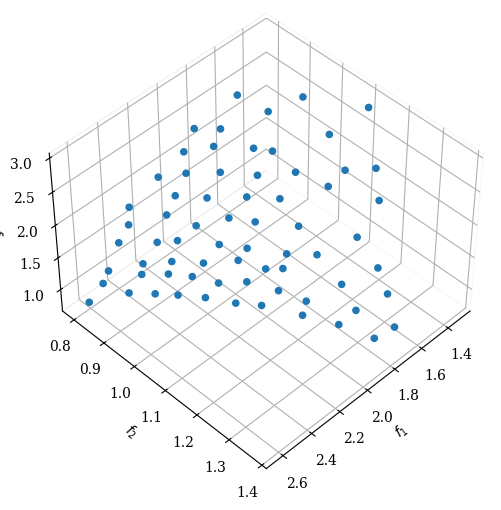

In [4]:
res_ngsa3 = minimize(
    wfg,
    ngsa3,
    ('n_gen', 350),
    seed = 42,
    verbose = False
)

Scatter().add(res_ngsa3.F).show()

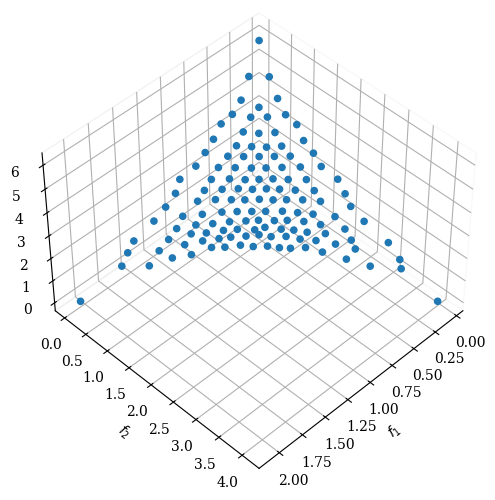

In [5]:
Scatter().add(wfg.pareto_front()).show()

## Mo-Gym info

In [6]:
env = mo_gym.make('mo-lunar-lander-v3')

## NGSA III

El algoritmo planteado por Deb (2014) descrito en pseudocódigo se ve de la siguiente manera:

In [7]:
# El algoritmo original se ve en pseudocódigo de la siguiente manera.
def NGSA_III(population):
    """
    Pseudocódigo general. (Algoritmo 1 en el paper original)
    """
    S = []
    i = 1
    Q = recom_mutation(population)
    R = population.union(Q)
    ParetoFronts = non_dom_sort(R)
    while len(S) < N: # Mejores N elementos de la población. N puede ser cualquier valor entero
        S = S.union(ParetoFronts[0])
        newPareto = ParetoFronts.pop()
        i += 1
    F_l = newPareto[0]
    if len(S) == N:
        return S # Regresamos la población completa. P_{t+1} = S_t
    else:
        pob = [ParetoFronts[i] for i in range(1, i-1)] # Unión desde 1 hasta l-1 (cuantificamos l mediante el contador i)
        K = N - len(pob)
        normalize(f, S, Z1, Z2, Z3)
        [pi, d] = associate(S, Z1)
        ref_point(Z1)
        return niching(K, rho, pi, d, Z1, F_l, pob)


def normalize(f, S, Z1, Z2, Z3):
    """
    Función de normalización. (Algoritmo 2 en el paper original)
    """
    for i in range(M):
        z = min([f1, ..., fk])
        f_j = fj - z #Para todos los elementos de S
        extreme_point = min(ASF(s, w))

    aj = [intercepts(_) for _ in range(M)]
    functions = [(f_i - z[0])/(aj[i] - z[i]) for i in range(M)]        
    if Z3 != None:
        Z2 = hyperplane_map(points)
    else:
        Z2 = Z3
    return Z2, functions

def associate(S, Z1, policy):
    """
    Asociación de valores. (Algoritmo 3)
    """
    ref_lines = [ref_line(z) for z in Z1]
    values = []
    d_list = []
    for s in S:
        for z in Z1:
            value = (s - z.T * s)/norm(z)
            values.append(value)
            
        policy.action = min([values])
        d = s - (policy.action.T * s)/norm(policy.action)
        d_list.append(d)
    return policy, d_list

def niching(K, rho, pi, d, Z1, F_l, pob):
    """
    Generación de la población final. (Algoritmo 4)
    """
    k = 1
    while k <= K:
        J_min = set(argmin(rho))
        j_bar = random(J_min)
        I_j = set(pi(s) for s in F_l)
        if I_j != 0:
            if rho != 0:
                pob = pob.union(argmin(d(s)))
            else:
                pob = pob.union(random(I_j))
            rho += 1
            F_l.remove(s)
            k += 1
        else:
            Z1.remove(j_bar)    

El pseudocódigo presentado previamente describe de manera directa el funcionamiento de NSGA III presentada en el artículo original. No obstante para una implementación adecauda tenemos que considerar la estructura de los problemas que queremos resolver (WFG extraído de Pymoo) al igual que las diferencias técnias. Para la implementación de este algoritmo se tomará como base la implementación presente en el siguiente repositorio: https://github.com/Xavier-MaYiMing/NSGA-III/tree/main

La implementación se divide en dos secciones la inicialización (definición de parámetros y ordenamiento no-dominado) y el aspecto genético (elección de mejores resultados). El ordenamiento es el ordenamiento de NSGA-II. Los puntos de referencia se siguen con respecto al artículo de NSGA-III.


https://www.egr.msu.edu/~kdeb/papers/k2012009.pdf ngsa3 paper

https://sci2s.ugr.es/sites/default/files/files/Teaching/OtherPostGraduateCourses/Metaheuristicas/Deb_NSGAII.pdf ngsa2 paper

https://github.com/haris989/NSGA-II/blob/master/NSGA%20II.py ngsa2 code

In [8]:
def combination(n, m):
    """
    Combinaciones de n en m. (nCm)
    n, m = int
    """
    if m == 0 or m == n:
        return 1
    elif m > n:
        return 0
    else:
        return np.math.factorial(n) // (np.math.factorial(m) * np.math.factorial(n - m))


def reference_points(npop, nvar):
    """
    Obtiene los puntos de referencia (equivalente a la obtención del conjunto Z^s)
    """
    h1 = 0
    while combination(h1 + nvar, nvar - 1) <= npop:
        h1 += 1
    points = np.array(list(combinations(np.arange(1, h1 + nvar), nvar - 1))) - np.arange(nvar - 1) - 1
    points = (np.concatenate((points, np.zeros((points.shape[0], 1)) + h1), axis=1) - np.concatenate((np.zeros((points.shape[0], 1)), points), axis=1)) / h1
    if h1 < nvar:
        h2 = 0
        while combination(h1 + nvar - 1, nvar - 1) + combination(h2 + nvar, nvar - 1) <= npop:
            h2 += 1
        if h2 > 0:
            temp_points = np.array(list(combinations(np.arange(1, h2 + nvar), nvar - 1))) - np.arange(nvar - 1) - 1
            temp_points = (np.concatenate((temp_points, np.zeros((temp_points.shape[0], 1)) + h2), axis=1) - np.concatenate((np.zeros((temp_points.shape[0], 1)), temp_points), axis=1)) / h2
            temp_points = temp_points / 2 + 1 / (2 * nvar)
            points = np.concatenate((points, temp_points), axis=0)
    return points


def nd_sort(objs):
    """
    Ordenamiento no-dominado (Correspondiente a la función Non-dominated-sort(R_t) del artículo)
    Es una instancia del fast-non-dominated-sort del artículo de NGSA-II, la dominancia está definida por las relaciones numéricas entre objs[i,j]
    """
    (npop, nobj) = objs.shape
    n = np.zeros(npop, dtype=int)  
    s = [] 
    rank = np.zeros(npop, dtype=int)
    ind = 0
    pareto_fronts = {ind: []}  
    for i in range(npop): # Primer for, verifica dominancias entre elementos y obtiene F_1
        s.append([])
        for j in range(npop):
            if i != j:
                less = equal = more = 0
                # Dominancia entre elementos y modificaciones de los contadores
                for k in range(nobj):
                    if objs[i, k] < objs[j, k]: 
                        less += 1
                    elif objs[i, k] == objs[j, k]:
                        equal += 1
                    else:
                        more += 1
                if less == 0 and equal != nobj:
                    n[i] += 1
                elif more == 0 and equal != nobj:
                    s[i].append(j)
        if n[i] == 0:
            pareto_fronts[ind].append(i)
            rank[i] = ind
            
    # While que genera los distintos niveles de frentes de Pareto
    while pareto_fronts[ind]: 
        pareto_fronts[ind + 1] = []
        for i in pareto_fronts[ind]:
            for j in s[i]:
                n[j] -= 1
                if n[j] == 0:
                    pareto_fronts[ind + 1].append(j)
                    rank[j] = ind + 1
        ind += 1
    pareto_fronts.pop(ind)
    return pareto_fronts, rank

In [9]:
def selection(pop, pc, rank, k=2):
    """
    Selección de elementos. Ocurre en el caso donde |S_t| != N y se tiene que "rellenar" el conjunto S_t.
    """
    (npop, nvar) = pop.shape
    nm = int(npop * pc)
    nm = nm if nm % 2 == 0 else nm + 1
    mating_pool = np.zeros((nm, nvar))
    for i in range(nm):
        [ind1, ind2] = np.random.choice(npop, k, replace=False)
        if rank[ind1] <= rank[ind2]:
            mating_pool[i] = pop[ind1]
        else:
            mating_pool[i] = pop[ind2]
    return mating_pool

def crossover(mating_pool, lb, ub, pc, eta_c):
    """
    Aspecto genético del algoritmo. Genera mejores elementos dentro de la población. (La verdad no entendía demasiado de este proceso, ayuda pls).
    Equivalente a un:
    
    from pymoo.operators.crossover.sbx import SBX
    crossover = SBX()
    """
    (noff, nvar) = mating_pool.shape
    nm = int(noff / 2)
    parent1 = mating_pool[:nm]
    parent2 = mating_pool[nm:]
    beta = np.zeros((nm, nvar))
    mu = np.random.random((nm, nvar))
    flag1 = mu <= 0.5
    flag2 = ~flag1
    beta[flag1] = (2 * mu[flag1]) ** (1 / (eta_c + 1))
    beta[flag2] = (2 - 2 * mu[flag2]) ** (-1 / (eta_c + 1))
    beta = beta * (-1) ** np.random.randint(0, 2, (nm, nvar))
    beta[np.random.random((nm, nvar)) < 0.5] = 1
    beta[np.tile(np.random.random((nm, 1)) > pc, (1, nvar))] = 1
    offspring1 = (parent1 + parent2) / 2 + beta * (parent1 - parent2) / 2
    offspring2 = (parent1 + parent2) / 2 - beta * (parent1 - parent2) / 2
    offspring = np.concatenate((offspring1, offspring2), axis=0)
    offspring = np.min((offspring, np.tile(ub, (noff, 1))), axis=0)
    offspring = np.max((offspring, np.tile(lb, (noff, 1))), axis=0)
    return offspring

def mutation(pop, lb, ub, pm, eta_m):
    """
    Mutación de la población.
    """
    (npop, nvar) = pop.shape
    lb = np.tile(lb, (npop, 1))
    ub = np.tile(ub, (npop, 1))
    site = np.random.random((npop, nvar)) < pm / nvar
    mu = np.random.random((npop, nvar))
    delta1 = (pop - lb) / (ub - lb)
    delta2 = (ub - pop) / (ub - lb)
    temp = np.logical_and(site, mu <= 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * ((2 * mu[temp] + (1 - 2 * mu[temp]) * (1 - delta1[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1)
    temp = np.logical_and(site, mu > 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * (1 - (2 * (1 - mu[temp]) + 2 * (mu[temp] - 0.5) * (1 - delta2[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)))
    pop = np.min((pop, ub), axis=0)
    pop = np.max((pop, lb), axis=0)
    return pop



def environmental_selection(pop, objs, zmin, npop, V):
    """
    Implementación de las líneas 13-18 del algoritmo 1.

    Esta implementación junta los algoritmos de Normalizing, Association, y Niching.
    """
    pfs, rank = nd_sort(objs)
    nobj = objs.shape[1]
    selected = np.full(pop.shape[0], False)
    ind = 0
    while np.sum(selected) + len(pfs[ind]) <= npop:
        selected[pfs[ind]] = True
        ind += 1
    K = npop - np.sum(selected)

    # Línea 13 algoritmo 1
    # Filtra sobre los k elementos del conjunto F_l
    objs1 = objs[selected]
    objs2 = objs[pfs[ind]]
    npop1 = objs1.shape[0]
    npop2 = objs2.shape[0]
    nv = V.shape[0]
    temp_objs = np.concatenate((objs1, objs2), axis=0)
    t_objs = temp_objs - zmin # Línea 3 alg2: Translate objectives 

    # Línea 4 del algoritmo 2 (Compute extreme points)
    extreme = np.zeros(nobj)
    w = 1e-6 + np.eye(nobj)
    for i in range(nobj):
        extreme[i] = np.argmin(np.max(t_objs / w[i], axis=1))

    # Línea 6 del algoritmo 2 (Compute intercepts)
    try:
        hyperplane = np.matmul(np.linalg.inv(t_objs[extreme.astype(int)]), np.ones((nobj, 1)))
        if np.any(hyperplane == 0):
            a = np.max(t_objs, axis=0)
        else:
            a = 1 / hyperplane
    except LinAlgError:
        a = np.max(t_objs, axis=0)
    t_objs /= a.reshape(1, nobj)

    # Algoritmo 3: Asociación
    cosine = 1 - cdist(t_objs, V, 'cosine') # Vectores traspuestos 
    distance = np.sqrt(np.sum(t_objs ** 2, axis=1).reshape(npop1 + npop2, 1)) * np.sqrt(1 - cosine ** 2) #Línea 6 del algoritmo 3
    dis = np.min(distance, axis=1)
    association = np.argmin(distance, axis=1) # Líneas 8-9 algoritmo 3
    temp_rho = dict(Counter(association[: npop1]))
    rho = np.zeros(nv)
    for key in temp_rho.keys():
        rho[key] = temp_rho[key]

    # Algoritmo 4: Niching
    choose = np.full(npop2, False)
    v_choose = np.full(nv, True)
    while np.sum(choose) < K:
        # Se calculan J_min, j_barra, I_j
        temp = np.where(v_choose)[0]
        jmin = np.where(rho[temp] == np.min(rho[temp]))[0]
        j = temp[np.random.choice(jmin)]
        I = np.where(np.bitwise_and(~choose, association[npop1:] == j))[0]

        # Elección de nuevos elementos de la población (Líneas 6-16)
        if I.size > 0:
            if rho[j] == 0:
                s = np.argmin(dis[npop1 + I])
            else:
                s = np.random.randint(I.size)
            choose[I[s]] = True
            rho[j] += 1
        else:
            v_choose[j] = False
    selected[np.array(pfs[ind])[choose]] = True
    return pop[selected], objs[selected], rank[selected]


def nsga3(npop, iterations, lb, ub, n_obj=3, pc=1, pm=1, eta_c=30, eta_m=20):
    """
    Implementación completa de NSGA-3

    npop = int ; Población para el algoritmo
    iterations = int ; Cantidad de iteraciones
    lb = array ; Restricciones inferiores del problema de optimización
    ub = array ; Restricciones superiores del problema de optimización
    n_obj = 3 ; Cantidad de objetivos, heredado de WFG1

    pc, pm, eta_c, eta_m = int ; Parámetros para la mutación y el cruce.
    """
    # Inicialización de parámetros 
    nvar = len(lb)  # the dimension of decision space
    pop = np.random.uniform(lb, ub, (npop, nvar))  # population
    objs = cal_obj(pop, n_obj)  # objectives
    V = reference_points(npop, n_obj)  # reference vectors
    zmin = np.min(objs, axis=0)  # ideal points
    [pfs, rank] = nd_sort(objs)  # Pareto rank

    # Step 2. The main loop
    for t in range(iterations):

        if (t + 1) % 50 == 0:
            print('Iteration: ' + str(t + 1) + ' completed.')

        # Step 2.1. Mating selection + crossover + mutation
        mating_pool = selection(pop, pc, rank)
        off = crossover(mating_pool, lb, ub, pc, eta_c)
        off = mutation(off, lb, ub, pm, eta_m)
        off_objs = cal_obj(off, n_obj)

        # Step 2.2. Environmental selection
        zmin = np.min((zmin, np.min(off_objs, axis=0)), axis=0)
        pop, objs, rank = environmental_selection(np.concatenate((pop, off), axis=0), np.concatenate((objs, off_objs), axis=0), zmin, npop, V)

    # Step 3. Sort the results
    pf = objs[rank == 0]
    return pf

In [10]:
"""
¿Cómo pingas ajusto esto para lo nuestro?
"""
def cal_obj(pop, nobj):
    # DTLZ1
    g = 100 * (pop.shape[1] - nobj + 1 + np.sum((pop[:, nobj - 1:] - 0.5) ** 2 - np.cos(20 * np.pi * (pop[:, nobj - 1:] - 0.5)), axis=1))
    objs = np.zeros((pop.shape[0], nobj))
    temp_pop = pop[:, : nobj - 1]
    for i in range(nobj):
        f = 0.5 * (1 + g)
        f *= np.prod(temp_pop[:, : temp_pop.shape[1] - i], axis=1)
        if i > 0:
            f *= 1 - temp_pop[:, temp_pop.shape[1] - i]
        objs[:, i] = f
    return objs

Iteration: 50 completed.
Iteration: 100 completed.
Iteration: 150 completed.


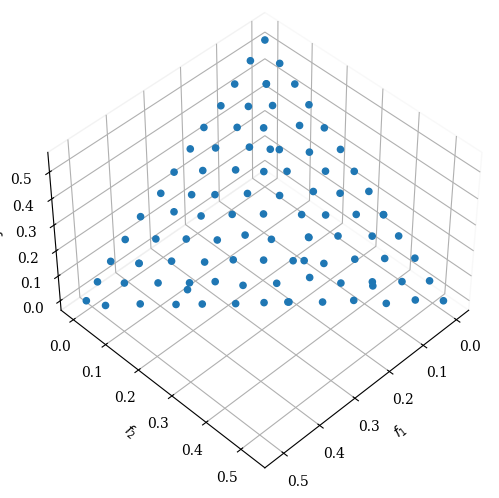

In [11]:
nsga = nsga3(100, 150, np.array([0] * 7), np.array([1] * 7))
Scatter().add(nsga).show()

## Pareto Q-Learning

In [12]:
def check_dom(vec1, vec2):
    """
    Revisa dominancia entre vectores
    """
    return np.all(vec1 >= vec2) and np.any(vec1 > vec2)

def discrete_state(state):
    """
    Discretiza el estado del lunar lander.
    """
    return tuple(np.round(state, decimals = 1))

def plot_results(full_rewards):
    r_hist = np.array(full_rewards)
    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.plot(r_hist[:, i], label=f"Objetivo {i+1}")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Recompensa por objetivo")
    plt.legend()
    plt.grid(True)
    plt.show()


class ParetoQL():
    def __init__(
        self,
        gamma,
    ):
        """
        Constructor: define epsilon, gamma, espacio de acciones (como int), el frente de Pareto actual, soluciones no dominadas, y la tabla Q.
        """
        self.epsilon = 0.1
        self.gamma = gamma
        self.act_space = env.action_space.n
        self.f_pareto = []
        self.non_dom = []
        self.Q_value = defaultdict(lambda: np.zeros((self.act_space, 4)))

    def reset(self):
        """
        Resetea ciertos valores del agente para un nuevo step de aprendizaje
        """
        self.f_pareto = []
        self.non_dom = []
        #self.Q_value = defaultdict(lambda: np.zeros((self.act_space, 4)))
        
    def get_action(self, state):
        """
        Obtiene una acción bajo los valores Q, permite cierto grado de exploración (random.uniform(0,1) < self.epsilon)
        """
        q_values = self.Q_value[state]
        for i in range(self.act_space):
            aux = False
            for j in range(self.act_space):
                if i != j:
                    if check_dom(j, i):
                        aux = True
                        break
            if not aux:
                self.non_dom.append(i)
        if np.random.uniform(0,1) < self.epsilon or len(self.non_dom) == 0:
            return np.random.randint(self.act_space)
        else:
            return np.random.choice(self.non_dom)

    def new_pareto(self, reward_vec):
        """
        Ajusta el frente de Pareto tras ciertas cantidades de iteraciones.
        """
        non_dom_new_iter = []
        for _ in self.non_dom:
            if check_dom(_, reward_vec):
                return self.non_dom
            else:
                non_dom_new_iter.append(_)
        return non_dom_new_iter

In [13]:
%%time

joder = ParetoQL(0.99)

alfa = 0.2
episodes = 10000
reward_per_ep = []

# Loop de entrenamiento. 
for i in range(episodes):
    if i % 100 == 0 :
        print('Episodio: {}'.format(i))
    
    # Inicio del episodio. Reset de entorno
    obs, info = env.reset()
    obs = discrete_state(obs)
    term_trunc = False
    ep_reward = np.zeros((4))

    while not term_trunc:
        action = joder.get_action(obs)
        new_state, reward, term, trunc, info = env.step(action)
        new_state = discrete_state(new_state) # Discretización previa a cada caso
        term_trunc = term or trunc

        next_action = np.max(joder.Q_value[new_state], axis = 0)
        joder.Q_value[obs][action] = (1 - alfa) * joder.Q_value[obs][action] + alfa * (np.array(reward) + joder.gamma * next_action) 
        
        obs = new_state
        ep_reward = np.add(ep_reward, reward)
        
    reward_per_ep.append(ep_reward)
    joder.f_pareto = joder.new_pareto(ep_reward)
    
env.close()

Episodio: 0
Episodio: 100
Episodio: 200
Episodio: 300
Episodio: 400
Episodio: 500
Episodio: 600
Episodio: 700
Episodio: 800
Episodio: 900
Episodio: 1000
Episodio: 1100
Episodio: 1200
Episodio: 1300
Episodio: 1400
Episodio: 1500
Episodio: 1600
Episodio: 1700
Episodio: 1800
Episodio: 1900
Episodio: 2000
Episodio: 2100
Episodio: 2200
Episodio: 2300
Episodio: 2400
Episodio: 2500
Episodio: 2600
Episodio: 2700
Episodio: 2800
Episodio: 2900
Episodio: 3000
Episodio: 3100
Episodio: 3200
Episodio: 3300
Episodio: 3400
Episodio: 3500
Episodio: 3600
Episodio: 3700
Episodio: 3800
Episodio: 3900
Episodio: 4000
Episodio: 4100
Episodio: 4200
Episodio: 4300
Episodio: 4400
Episodio: 4500
Episodio: 4600
Episodio: 4700
Episodio: 4800
Episodio: 4900
Episodio: 5000
Episodio: 5100
Episodio: 5200
Episodio: 5300
Episodio: 5400
Episodio: 5500
Episodio: 5600
Episodio: 5700
Episodio: 5800
Episodio: 5900
Episodio: 6000
Episodio: 6100
Episodio: 6200
Episodio: 6300
Episodio: 6400
Episodio: 6500
Episodio: 6600
Episodi

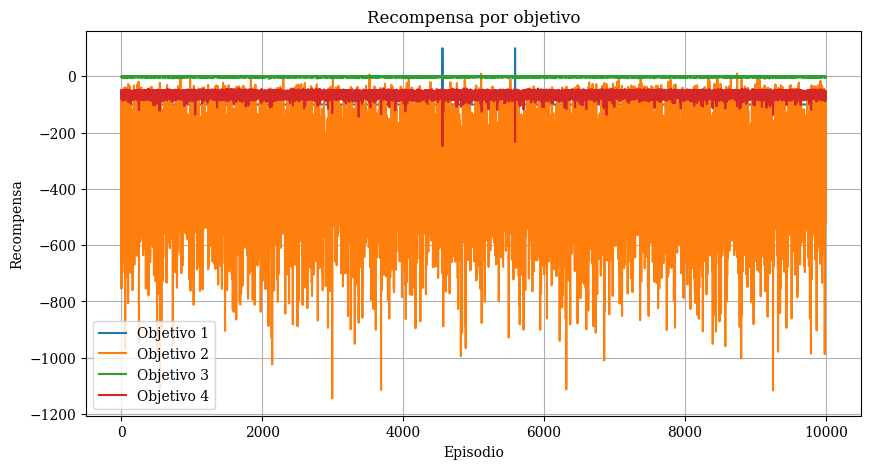

In [14]:
plot_results(reward_per_ep)

## Métodos de descenso

In [15]:
env_input_shape = env.observation_space.shape[0]
env_output_shape = env.action_space.n

class Policy(nn.Module):
    """
    Política base para mo-lunar-lander
    """
    def __init__(
        self, 
        input_shape, 
        output_shape
    ):
        super().__init__()
        self.f1 = nn.Linear(input_shape, 512)
        self.f2 = nn.Linear(512, 128)
        self.output = nn.Linear(128, output_shape)

    def forward(self, state):
        action = F.relu(self.f1(state))
        action = F.relu(self.f2(action))
        logits = F.relu(self.output(action))
        softmax = F.softmax(logits, dim = -1)
        return softmax
        
    def action_probs(self, state):
        """
        Obtiene la probabilidad de una acción, necesario para el cálculo del gradiente por objetivo.
        """
        action = F.relu(self.f1(state))
        action = F.relu(self.f2(action))
        logits = F.relu(self.output(action))
        softmax = F.softmax(logits, dim = -1)
        category = Categorical(softmax)
        action = category.sample()
        return category.log_prob(action).tolist()

    def act(self, state):
        """
        Obtiene la acción explícita, necesario para la ejecución del loop de entrenamiento.
        """
        action = self(state)
        action = torch.multinomial(action, num_samples = 1).tolist()[0]
        return action

In [16]:
gamma = 0.99
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = Policy(env_input_shape, env_output_shape).to(dev)

Episodio: 0
Episodio: 100
Episodio: 200
Episodio: 300
Episodio: 400
Episodio: 500
Episodio: 600
Episodio: 700
Episodio: 800
Episodio: 900
Episodio: 1000
Episodio: 1100
Episodio: 1200
Episodio: 1300
Episodio: 1400
Episodio: 1500
Episodio: 1600
Episodio: 1700
Episodio: 1800
Episodio: 1900
Episodio: 2000
Episodio: 2100
Episodio: 2200
Episodio: 2300
Episodio: 2400
Episodio: 2500
Episodio: 2600
Episodio: 2700
Episodio: 2800
Episodio: 2900
Episodio: 3000
Episodio: 3100
Episodio: 3200
Episodio: 3300
Episodio: 3400
Episodio: 3500
Episodio: 3600
Episodio: 3700
Episodio: 3800
Episodio: 3900
Episodio: 4000
Episodio: 4100
Episodio: 4200
Episodio: 4300
Episodio: 4400
Episodio: 4500
Episodio: 4600
Episodio: 4700
Episodio: 4800
Episodio: 4900
Episodio: 5000
Episodio: 5100
Episodio: 5200
Episodio: 5300
Episodio: 5400
Episodio: 5500
Episodio: 5600
Episodio: 5700
Episodio: 5800
Episodio: 5900
Episodio: 6000
Episodio: 6100
Episodio: 6200
Episodio: 6300
Episodio: 6400
Episodio: 6500
Episodio: 6600
Episodi

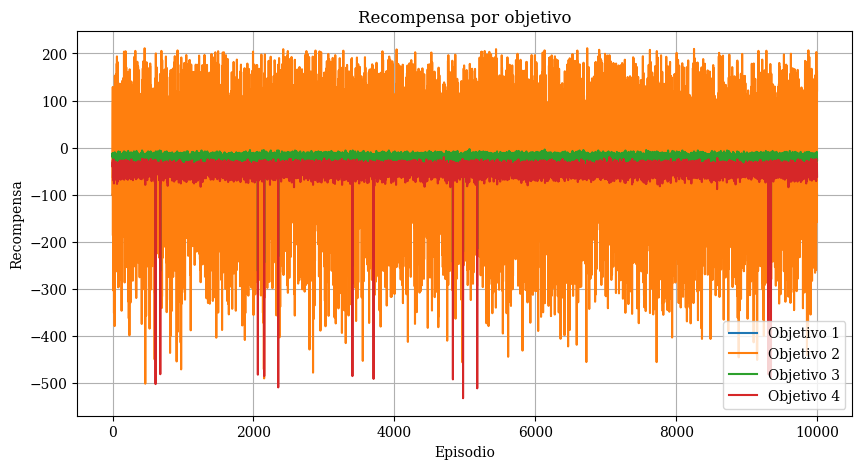

CPU times: total: 49min 7s
Wall time: 50min 29s


In [17]:
%%time
ds_full_rewards = []

for i in range(episodes):
    if i % 100 == 0 :
        print('Episodio: {}'.format(i))
    ep_reward = np.zeros((4)) # Para graficar
    ep_rewards = [] # Para entrenar
    obs, info = env.reset()
    obs = torch.from_numpy(obs).to(dev)
    term_trunc = False

    # Probabilidad de ejecución de cada acción
    action_probas = []

    # Loop de juego
    while not term_trunc:
        action = policy_net.act(obs)
        next_obs, rewards, term, trunc, info = env.step(action)
        term_trunc = term or trunc

        action_probas.append(policy_net.action_probs(obs))
        
        obs = torch.from_numpy(next_obs).to(dev)
        
        ep_reward = np.add(ep_reward, rewards)
        ep_rewards.append(rewards)

    # Para graficar
    ds_full_rewards.append(ep_reward)

    # Cálculo de gradientes por recompensa
    obj_gradient = []
    action_probas = torch.Tensor(action_probas)

    for k in range(len(rewards)):
        ep_k = [_[k] for _ in ep_rewards] # Para entrenar
        k_grad = torch.Tensor(ep_k).to(dev)
        loss_j = sum(-lp * r for lp, r in zip(action_probas, k_grad))

        loss_grad = torch.Tensor(loss_j).to(dev)
        loss_grad.requires_grad_()
        loss_grad.backward() # Aprendizaje por cada objetivo
        obj_gradient.append(loss_grad)
        

plot_results(ds_full_rewards)